# Mamba sampling for a simple linear regression

This notebook is a modification of an example in the documentation of the Mamba package

In [1]:
addprocs(4);
using Compat, Distributions, Mamba

exception on 1: ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
exception on 1: ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
exception on 1: ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
exception on 1: ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in ope

A simple linear regression model is given in the [Mamba manual](http://mambajl.readthedocs.org/en/latest/) as

In [2]:
model = Model(
  y = Stochastic(1, @modelexpr(μ, σ², MvNormal(μ, √σ²)), false),
  μ = Logical(1, @modelexpr(X, β, XtX, Xty, X * β), false),
  β = Stochastic(1,:(MvNormalCanon(2,0.001))),
  σ² = Stochastic(:(InverseGamma(0.001, 0.001)))
);

The directed acyclic graph (DAG) of the model is

In [3]:
draw(model; filename = "model.dot")

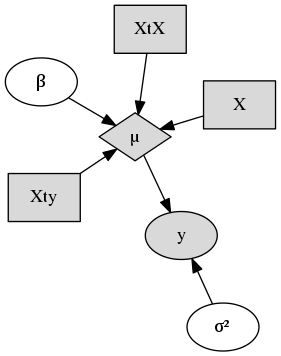

In [4]:
using GraphViz
open("model.dot","r") do io Graph(io) end

Because the priors are conjugate we can define explicit samplers.

In [5]:
Gibbs_β = Sampler([:β],
  @modelexpr(β, σ², XtX, Xty,
    begin
      potential = Xty / σ²
      precision = XtX / σ².value + invcov(β.distr)
      rand(MvNormalCanon(potential, precision))
    end
  )
);
Gibbs_σ² = Sampler([:σ²],
  @modelexpr(β, σ², μ, y, 
    begin
      a = length(y) / 2.0 + shape(σ².distr)
      b = sumabs2(y - μ) / 2.0 + scale(σ².distr)
      rand(InverseGamma(a, b))
    end
  )
);
setsamplers!(model,[Gibbs_β, Gibbs_σ²]);

Next we formulate the data

In [6]:
using PDMats;
const X = hcat(ones(5),[1.:5]);
const y = [1.,3.,3.,3.,5.];
line = @compat Dict{Symbol,Any}(
  :X => X,
  :y => y,
  :XtX => PDMat(X'X),
  :Xty => X'y
);
setinputs!(model, line);

In [7]:
show(model);

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[]
-------------------------------------------------------------------------------
XtX:
PDMat(2,[5.0 15.0
 15.0 55.0],Cholesky{Float64} with factor:
[2.23606797749979 6.7082039324993685
 0.0 3.1622776601683804])
-------------------------------------------------------------------------------
Xty:
[15.0,53.0]
-------------------------------------------------------------------------------
σ²:
A monitored node of type "Stochastic{Float64}"
NaN
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "Logical{Array{Float64,1}}"
[]
-------------------------------------------------------------------------------
X:
[1.0 1.0
 1.0 2.0
 1.0 3.0
 1.0 4.0
 1.0 5.0]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "Stochastic{

Set the random number generator seed for reproducibility

In [8]:
srand(1234321);

In [9]:
setinits!(model,@compat(Dict{Symbol,Any}(:y=>y,:σ²=>rand(Gamma(1.,1.)),:β=>randn(2))))

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[1.70391,-1.17272]
-------------------------------------------------------------------------------
XtX:
PDMat(2,2x2 Array{Float64,2}:
  5.0  15.0
 15.0  55.0,Cholesky{Float64} with factor:
2x2 Triangular{Float64,Array{Float64,2},:U,false}:
 2.23607  6.7082 
 0.0      3.16228)
-------------------------------------------------------------------------------
Xty:
[15.0,53.0]
-------------------------------------------------------------------------------
σ²:
A monitored node of type "Stochastic{Float64}"
0.43397862718543084
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "Logical{Array{Float64,1}}"
[0.531181,-0.641543,-1.81427,-2.98699,-4.15972]
-------------------------------------------------------------------------------
X:
5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 

Now check that the samplers are working as expected.

In [10]:
simulate!(model)

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[-0.412399,1.19352]
-------------------------------------------------------------------------------
XtX:
PDMat(2,2x2 Array{Float64,2}:
  5.0  15.0
 15.0  55.0,Cholesky{Float64} with factor:
2x2 Triangular{Float64,Array{Float64,2},:U,false}:
 2.23607  6.7082 
 0.0      3.16228)
-------------------------------------------------------------------------------
Xty:
[15.0,53.0]
-------------------------------------------------------------------------------
σ²:
A monitored node of type "Stochastic{Float64}"
0.8449240576397794
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "Logical{Array{Float64,1}}"
[0.78112,1.97464,3.16816,4.36168,5.55519]
-------------------------------------------------------------------------------
X:
5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3

In [11]:
simulate!(model)

Object of type "Model"
-------------------------------------------------------------------------------
β:
A monitored node of type "Stochastic{Array{Float64,1}}"
[-1.99062,1.53223]
-------------------------------------------------------------------------------
XtX:
PDMat(2,2x2 Array{Float64,2}:
  5.0  15.0
 15.0  55.0,Cholesky{Float64} with factor:
2x2 Triangular{Float64,Array{Float64,2},:U,false}:
 2.23607  6.7082 
 0.0      3.16228)
-------------------------------------------------------------------------------
Xty:
[15.0,53.0]
-------------------------------------------------------------------------------
σ²:
A monitored node of type "Stochastic{Float64}"
3.5369506411620346
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "Logical{Array{Float64,1}}"
[-0.458389,1.07384,2.60607,4.1383,5.67053]
-------------------------------------------------------------------------------
X:
5x2 Array{Float64,2}:
 1.0  1.0
 1.0  2.0
 1.0  3

The initial values, except for the response, `y`, are chosen at random.  There will be 4 chains, each running on a separate process.

In [12]:
inits = [@compat Dict{Symbol,Any}(
    :y => line[:y],
    :β => rand(Normal(0, 1), 2),
    :σ² => rand(Gamma(1, 1))) for i in 1:4]  # 4 chains

4-element Array{Dict{Symbol,Any},1}:
 [:β=>[-0.363027,-0.377948],:σ²=>0.6970458237333107,:y=>[1.0,3.0,3.0,3.0,5.0]] 
 [:β=>[-0.0199111,-0.0102739],:σ²=>2.752905175455911,:y=>[1.0,3.0,3.0,3.0,5.0]]
 [:β=>[-0.982226,-0.724709],:σ²=>1.3113883576704326,:y=>[1.0,3.0,3.0,3.0,5.0]] 
 [:β=>[0.577596,0.739668],:σ²=>0.9871646651094341,:y=>[1.0,3.0,3.0,3.0,5.0]]   

In [13]:
sim = mcmc(model, line, inits, 10000, burnin=2500, thin=2, chains=4);

MCMC Simulation of 10000 Iterations x 4 Chains...

	From worker 2:	Chain 1:   0% [0:09:10 of 0:09:11 remaining]
	From worker 3:	Chain 2:   0% [0:09:18 of 0:09:19 remaining]
	From worker 4:	Chain 3:   0% [0:09:09 of 0:09:10 remaining]
	From worker 2:	Chain 1:  10% [0:00:06 of 0:00:06 remaining]
	From worker 3:	Chain 2:  10% [0:00:06 of 0:00:07 remaining]
	From worker 5:	Chain 4:   0% [0:09:10 of 0:09:11 remaining]
	From worker 4:	Chain 3:  10% [0:00:06 of 0:00:06 remaining]
	From worker 2:	Chain 1:  20% [0:00:03 of 0:00:03 remaining]
	From worker 4:	Chain 3:  20% [0:00:03 of 0:00:03 remaining]
	From worker 5:	Chain 4:  10% [0:00:06 of 0:00:06 remaining]
	From worker 3:	Chain 2:  20% [0:00:03 of 0:00:04 remaining]
	From worker 2:	Chain 1:  30% [0:00:02 of 0:00:03 remaining]
	From worker 4:	Chain 3:  30% [0:00:02 of 0:00:03 remaining]
	From worker 5:	Chain 4:  20% [0:00:03 of 0:00:04 remaining]
	From worker 3:	Chain 2:  30% [0:00:02 of 0:00:03 remaining]
	From worker 2:	Chain 1:  40% [0:0

The first time that chains are simulated the various samplers must be compiled.  Once they have been compiled sampling is very fast

In [14]:
@time mcmc(model, line, inits, 10000, burnin=2500, thin=2, chains=4);

MCMC Simulation of 10000 Iterations x 4 Chains...

	From worker 2:	Chain 1:   0% [0:00:00 of 0:00:00 remaining]
	From worker 3:	Chain 2:   0% [0:00:00 of 0:00:00 remaining]
	From worker 4:	Chain 3:   0% [0:00:00 of 0:00:00 remaining]
	From worker 5:	Chain 4:   0% [0:00:00 of 0:00:00 remaining]
	From worker 3:	Chain 2:  10% [0:00:00 of 0:00:00 remaining]
	From worker 2:	Chain 1:  10% [0:00:00 of 0:00:00 remaining]
	From worker 4:	Chain 3:  10% [0:00:00 of 0:00:00 remaining]
	From worker 5:	Chain 4:  10% [0:00:00 of 0:00:00 remaining]
	From worker 3:	Chain 2:  20% [0:00:00 of 0:00:00 remaining]
	From worker 2:	Chain 1:  20% [0:00:00 of 0:00:00 remaining]
	From worker 5:	Chain 4:  20% [0:00:00 of 0:00:00 remaining]
	From worker 4:	Chain 3:  20% [0:00:00 of 0:00:00 remaining]
	From worker 3:	Chain 2:  30% [0:00:00 of 0:00:00 remaining]
	From worker 2:	Chain 1:  30% [0:00:00 of 0:00:00 remaining]
	From worker 5:	Chain 4:  30% [0:00:00 of 0:00:00 remaining]
	From worker 4:	Chain 3:  30% [0:0

In [15]:
describe(sim)

Iterations = 2502:10000
Thinning interval = 2
Chains = 1,2,3,4
Samples per chain = 3750

Empirical Posterior Estimates:
4x6 Array{Any,2}:
 ""            "Mean"    "SD"      "Naive SE"   "MCSE"          "ESS"
 "\u3b2[1]"   0.594408  1.24958   0.0102028    0.0101511   15000.0   
 "\u3b2[2]"   0.800651  0.380084  0.00310337   0.00297627  15000.0   
 "\u3c3\ub2"  1.44846   4.20236   0.0343121    0.0416222   12365.5   

Quantiles:
4x6 Array{Any,2}:
 ""             "2.5%"     "25.0%"     "50.0%"   "75.0%"   "97.5%"
 "\u3b2[1]"   -1.75501    0.00413018  0.594653  1.17068   2.9862  
 "\u3b2[2]"    0.0781067  0.626201    0.798912  0.977558  1.52393 
 "\u3c3\ub2"   0.170356   0.385363    0.671092  1.30103   7.28947 


In [16]:
hpd(sim)

4x3 Array{Any,2}

:
 ""             "2.5%"     "97.5%"
 "\u3b2[1]"   -1.74743    2.99064 
 "\u3b2[2]"    0.0749481  1.51923 
 "\u3c3\ub2"   0.0830024  4.53075 

In [17]:
p = plot(sim);

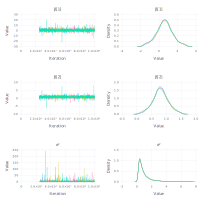

In [18]:
draw(p)